# Chapter 3 - Deep Q-learning
### Deep Reinforcement Learning *in Action*

##### Listing 3.1

In [1]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [2]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
game.reward()

-1

In [ ]:
game.board.render_np()

##### Listing 3.2

In [2]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

# 定义神经网络模型的层结构
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

# 定义损失函数和优化器
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 强化学习的参数
gamma = 0.9  # 折扣因子，影响对未来奖励的重视程度
epsilon = 1.0  # ε-贪心法中的贪心因子，用于在探索和利用之间取得平衡

# 注意：下面的学习率和优化器定义可能是重复的，可能存在错误
# learning_rate = 1e-3
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 这部分可能需要确认是否存在错误

# 可能的错误：下面的赋值可能会覆盖之前的值
gamma = 0.9
epsilon = 1.0

##### Listing 3.3

In [3]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [6]:
epochs = 1000
losses = []  # 用于存储每个epoch的损失值的列表

for i in range(epochs):  # 迭代训练周期
    game = Gridworld(size=4, mode='static')  # 创建一个4x4的Gridworld实例
    
    # 初始化当前状态，并添加一些随机噪声
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0  # D
    
    # 将NumPy数组转换为PyTorch张量
    state1 = torch.from_numpy(state_).float()  # E
    
    status = 1  # 游戏状态，1表示游戏正在进行中
    
    while status == 1:  # 当游戏状态为1时（游戏进行中）
        qval = model(state1)  # 获取当前状态的Q值（模型的输出）  # H
        qval_ = qval.data.numpy()
        
        # ε-贪心法：以ε的概率随机选择动作，以1-ε的概率选择Q值最大的动作
        if random.random() < epsilon:  # I
            action_ = np.random.randint(0, 4)  # 随机选择动作
        else:
            action_ = np.argmax(qval_)  # 选择Q值最大的动作
        
        action = action_set[action_]  # 获取选择的动作  # J
        
        game.makeMove(action)  # 执行动作并更新游戏状态  # K
        
        # 获取新的状态，并添加一些随机噪声
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0  # L
        
        # 将NumPy数组转换为PyTorch张量
        state2 = torch.from_numpy(state2_).float()  # L
        
        reward = game.reward()  # 获取当前动作的奖励值
        
        with torch.no_grad():
            newQ = model(state2.reshape(1, 64))  # 获取新状态的Q值（模型的输出）
        
        maxQ = torch.max(newQ)  # 获取新状态的最大Q值  # M
        
        # 根据奖励计算目标Q值Y
        if reward == -1:  # N
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_]  # 获取当前状态选择的动作的Q值  # O
        
        # 计算损失值
        loss = loss_fn(X, Y)  # P
        
        print(i, loss.item())
        clear_output(wait=True)
        
        optimizer.zero_grad()  # 清零梯度
        loss.backward()  # 反向传播计算梯度
        losses.append(loss.item())  # 记录损失值
        optimizer.step()  # 更新模型参数
        
        state1 = state2  # 更新当前状态为新状态
        
        if reward != -1:  # 如果游戏结束（达到目标或走到不可通行的位置）
            status = 0  # 将游戏状态置为0，结束当前epoch
    
    if epsilon > 0.1:  # 逐渐减小贪心因子ε
        epsilon -= (1 / epochs)  # R


999 0.006217891350388527


Text(0, 0.5, 'Loss')

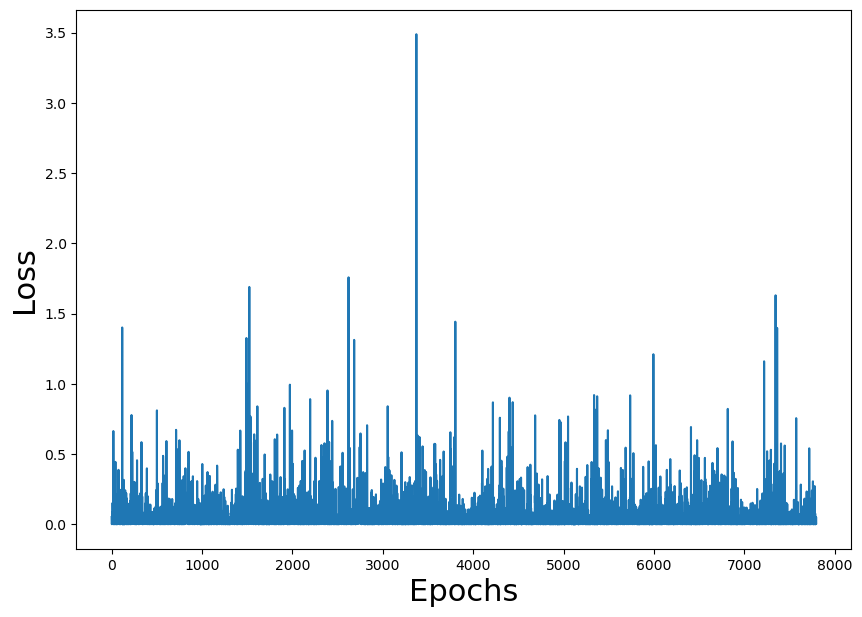

In [7]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

##### PyTorch Automatic Differentiation Review

In [8]:
# 创建张量 m，并设置 requires_grad 为 True，以便后续进行梯度计算
m = torch.Tensor([2.0])
m.requires_grad = True

# 创建张量 b，并设置 requires_grad 为 True，以便后续进行梯度计算
b = torch.Tensor([1.0])
b.requires_grad = True

# 定义线性模型函数
def linear_model(x, m, b):
    # 计算线性模型的输出，y = m*x + b
    y = m * x + b
    return y
# m 被初始化为包含一个数值 2.0 的标量张量：

In [9]:
#with torch.no_grad():
y = linear_model(torch.Tensor([4]),m,b)

In [10]:
y.grad_fn

In [11]:
y.backward()

In [12]:
m.grad

tensor([4.])

##### Listing 3.4

In [16]:
def test_model(model, mode='random', display=True):       # mode='static'
    i = 0
    
    # 创建 Gridworld 游戏实例
    test_game = Gridworld(mode=mode)
    
    # 初始化游戏状态，并添加一些随机噪声
    state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    
    # 将NumPy数组转换为PyTorch张量
    state = torch.from_numpy(state_).float()
    
    if display:
        print("Initial State:")
        print(test_game.display())
    
    status = 1
    
    while status == 1:  # 当游戏状态为1时（游戏进行中）
        qval = model(state)
        qval_ = qval.data.numpy()
        
        # 选择Q值最大的动作
        action_ = np.argmax(qval_)  # B
        
        # 获取对应的动作
        action = action_set[action_]
        
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        
        test_game.makeMove(action)
        
        # 获取新的状态，并添加一些随机噪声
        state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        
        # 将NumPy数组转换为PyTorch张量
        state = torch.from_numpy(state_).float()
        
        if display:
            print(test_game.display())
        
        reward = test_game.reward()
        
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        
        i += 1
        
        if i > 15:
            if display:
                print("Game lost; too many moves.")
            break
    
    # 判断游戏是否胜利
    win = True if status == 2 else False
    return win


In [17]:
test_model(model)

Initial State:
[[' ' 'W' ' ' '-']
 ['P' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: u
[['P' 'W' ' ' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['P' 'W' ' ' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['P' 'W' ' ' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['P' 'W' ' ' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['P' 'W' ' ' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: l
[['P' 'W' ' ' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: l
[['P' 'W' ' ' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 7; Taking action: l
[['P' 'W' ' ' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 8; Taking action: l
[['P' 'W' ' ' '-']
 [' ' ' ' ' ' ' ']
 [

False

##### Listing 3.5

In [18]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [19]:
from collections import deque

# 设置训练的总周期数
epochs = 5000
# 用于存储损失的列表
losses = []
# 设置经验回放记忆的总大小
mem_size = 1000  # A
# 设置每次训练时使用的经验样本数量
batch_size = 200  # B
# 创建经验回放队列作为双端队列，限制队列大小
replay = deque(maxlen=mem_size)  # C
# 设置每局游戏最大的移动步数
max_moves = 50  # D

# 循环执行训练周期
for i in range(epochs):
    # 创建 Gridworld 游戏实例
    game = Gridworld(size=4, mode='random')
    # 初始化游戏状态，并添加一些随机噪声
    state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
    # 将NumPy数组转换为PyTorch张量
    state1 = torch.from_numpy(state1_).float()
    # 游戏状态，1表示游戏进行中
    status = 1
    # 记录移动步数
    mov = 0
    
    while status == 1:  # 当游戏状态为1时（游戏进行中）
        mov += 1
        # 计算模型对当前状态的Q值  # E
        qval = model(state1)
        qval_ = qval.data.numpy()
        
        # 使用ε-贪心策略选择动作  # F
        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        
        # 获取对应的动作
        action = action_set[action_]
        # 执行动作并更新游戏状态
        game.makeMove(action)
        
        # 获取新的状态，并添加一些随机噪声
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
        # 将NumPy数组转换为PyTorch张量
        state2 = torch.from_numpy(state2_).float()
        # 获取当前动作的奖励
        reward = game.reward()
        # 游戏是否结束的标志
        done = True if reward > 0 else False
        # 创建经验元组，包含当前状态、动作、奖励、下一状态和游戏是否结束的信息  # G
        exp = (state1, action_, reward, state2, done)
        # 将经验元组添加到经验回放队列中  # H
        replay.append(exp)
        # 更新当前状态为新状态
        state1 = state2
        
        # 如果经验回放队列长度超过了设定的minibatch大小，开始进行训练  # I
        if len(replay) > batch_size:
            # 从经验回放队列中随机抽取一部分经验元组，形成minibatch  # J
            minibatch = random.sample(replay, batch_size)
            # 将minibatch中的各个组件分离为不同的Tensor  # K
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])
            
            # 计算当前状态的Q值，用于计算梯度  # L
            Q1 = model(state1_batch)
            # 计算下一状态的Q值，不计算梯度  # M
            with torch.no_grad():
                Q2 = model(state2_batch)
            
            # 计算目标Q值，用于更新模型  # N
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
            # 计算损失并输出  # O
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            # 梯度清零
            optimizer.zero_grad()
            # 反向传播计算梯度
            loss.backward()
            # 记录损失值
            losses.append(loss.item())
            # 更新模型参数
            optimizer.step()

        # 如果游戏结束或者达到最大移动步数，重置游戏状态和移动步数  # O
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0

# 将损失值转换为NumPy数组
losses = np.array(losses)


#A Set the total size of the experience replay memory
#B Set the minibatch size
#C Create the memory replay as a deque list
#D Maximum number of moves before game is over
#E Compute Q-values from input state in order to select action
#F Select action using epsilon-greedy strategy
#G Create experience of state, reward, action and next state as a tuple
#H Add experience to experience replay list
#I If replay list is at least as long as minibatch size, begin minibatch training
#J Randomly sample a subset of the replay list
#K Separate out the components of each experience into separate minibatch tensors
#L Re-compute Q-values for minibatch of states to get gradients
#M Compute Q-values for minibatch of next states but don't compute gradients
#N Compute the target Q-values we want the DQN to learn
#O If game is over, reset status and mov number

4999 0.020231256261467934


In [20]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

Text(0, 0.5, 'Loss')

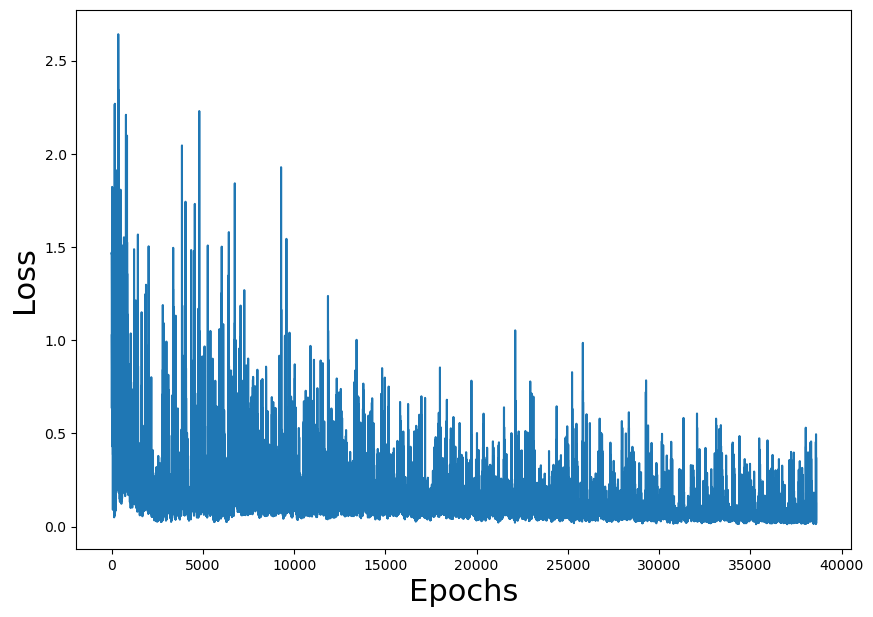

In [21]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [22]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 893
Win percentage: 89.3%


In [23]:
test_model(model, mode='random')

Initial State:
[[' ' 'W' ' ' ' ']
 ['P' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 0; Taking action: r
[[' ' 'W' ' ' ' ']
 [' ' 'P' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 1; Taking action: r
[[' ' 'W' ' ' ' ']
 [' ' ' ' 'P' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 2; Taking action: r
[[' ' 'W' ' ' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Game won! Reward: 10


True

###### Listing 3.7

In [24]:
import copy

# 定义神经网络的层的大小
l1 = 64
l2 = 150
l3 = 100
l4 = 4

# 创建主模型
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

# 创建目标网络，并使用深拷贝复制主模型的结构
model2 = copy.deepcopy(model)  # A

# 将目标网络的参数初始化为主模型的参数
model2.load_state_dict(model.state_dict())  # B

# 定义损失函数、学习率和优化器
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 设置折扣因子和ε-贪心策略的参数
gamma = 0.9
epsilon = 0.3

In [25]:
from collections import deque

# 定义训练周期数
epochs = 5000
# 用于存储损失的列表
losses = []
# 设置经验回放记忆的总大小
mem_size = 1000
# 设置每次训练时使用的经验样本数量
batch_size = 200
# 创建经验回放队列作为双端队列，限制队列大小
replay = deque(maxlen=mem_size)
# 设置每局游戏最大的移动步数
max_moves = 50
# 记录同步频率
sync_freq = 500  # A
# 记录总的动作次数
j = 0

# 循环执行训练周期
for i in range(epochs):
    # 创建 Gridworld 游戏实例
    game = Gridworld(size=4, mode='random')
    # 初始化游戏状态，并添加一些随机噪声
    state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
    # 将NumPy数组转换为PyTorch张量
    state1 = torch.from_numpy(state1_).float()
    # 游戏状态，1表示游戏进行中
    status = 1
    # 记录移动步数
    mov = 0
    
    while status == 1:  # 当游戏状态为1时（游戏进行中）
        j += 1  # 记录总的动作次数
        mov += 1
        # 计算模型对当前状态的Q值
        qval = model(state1)
        qval_ = qval.data.numpy()
        
        # 使用ε-贪心策略选择动作
        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        
        # 获取对应的动作
        action = action_set[action_]
        # 执行动作并更新游戏状态
        game.makeMove(action)
        
        # 获取新的状态，并添加一些随机噪声
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
        # 将NumPy数组转换为PyTorch张量
        state2 = torch.from_numpy(state2_).float()
        # 获取当前动作的奖励
        reward = game.reward()
        # 游戏是否结束的标志
        done = True if reward > 0 else False
        # 创建经验元组，包含当前状态、动作、奖励、下一状态和游戏是否结束的信息
        exp = (state1, action_, reward, state2, done)
        # 将经验元组添加到经验回放队列中
        replay.append(exp)  # H
        # 更新当前状态为新状态
        state1 = state2
        
        # 如果经验回放队列长度超过了设定的minibatch大小，开始进行训练
        if len(replay) > batch_size:
            # 从经验回放队列中随机抽取一部分经验元组，形成minibatch
            minibatch = random.sample(replay, batch_size)
            # 将minibatch中的各个组件分离为不同的Tensor
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])
            
            # 计算当前状态的Q值，用于计算梯度
            Q1 = model(state1_batch)
            # 使用目标网络获取下一状态的Q值  # B
            with torch.no_grad():
                Q2 = model2(state2_batch)
            
            # 计算目标Q值，用于更新模型
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
            # 计算损失并输出
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            # 梯度清零
            optimizer.zero_grad()
            # 反向传播计算梯度
            loss.backward()
            # 记录损失值
            losses.append(loss.item())
            # 更新模型参数
            optimizer.step()
            
            # 每隔一定的动作次数，同步目标网络的参数到主模型
            if j % sync_freq == 0:  # C
                model2.load_state_dict(model.state_dict())

        # 如果游戏结束或者达到最大移动步数，重置游戏状态和移动步数
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
# 将损失值转换为NumPy数组
losses = np.array(losses)

4999 0.016336964443325996


Text(0, 0.5, 'Loss')

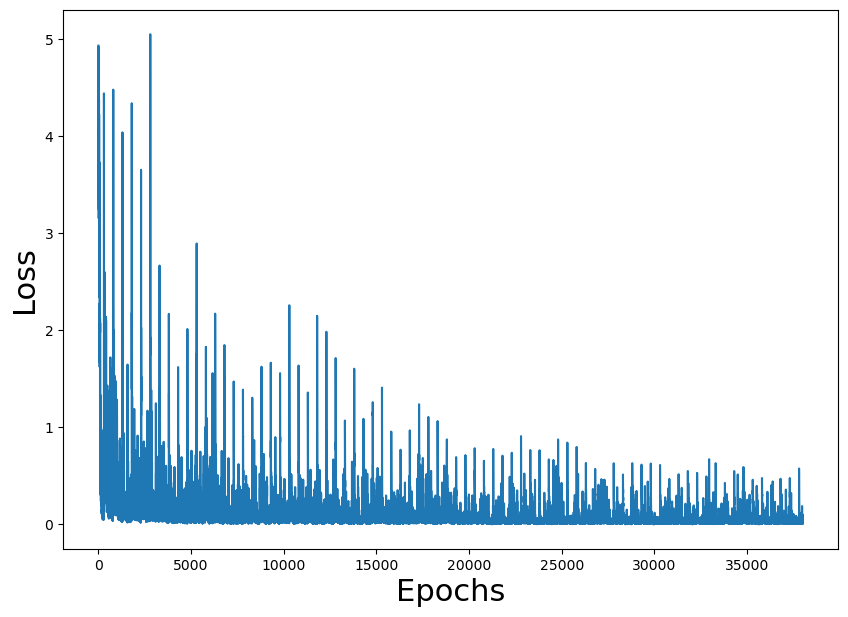

In [26]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [27]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 902
Win percentage: 90.2%
